In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import yfinance as yf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import kstest_normal,het_arch
from statsmodels.tsa.stattools import acf, q_stat, adfuller  

from scipy.stats import probplot, moment, shapiro, jarque_bera

In [4]:
seed = 2022 

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
img_dir = os.path.join('..', 'img')

In [7]:
start = datetime(2010, 1, 1)
end = datetime(2022, 10, 1)

In [8]:
ticker_name = "^BVSP"
ticker = yf.Ticker(ticker_name)
df = ticker.history(start=start, 
                    end=end, 
                    interval="1d")

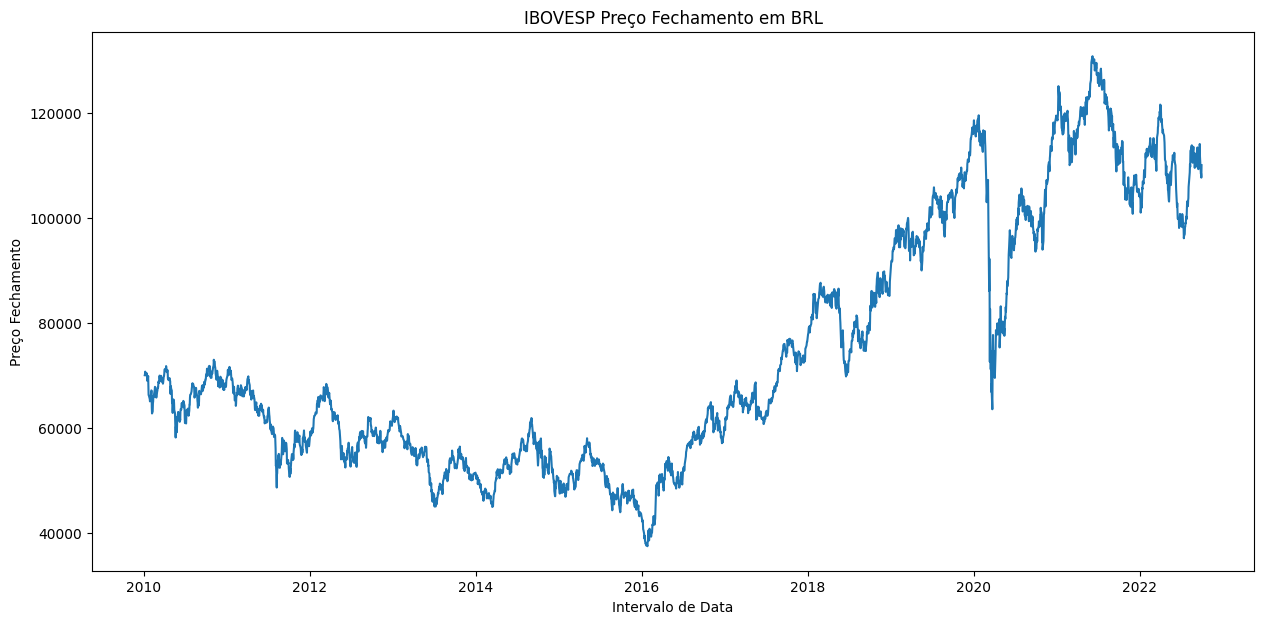

In [9]:
plt.figure(figsize=(15,7))
plt.title('IBOVESP Preço Fechamento em BRL')
plt.plot(df.Close)
plt.xlabel('Intervalo de Data')
plt.ylabel('Preço Fechamento')
plt.savefig(os.path.join(img_dir, 'ibovesp-preco.jpg'), dpi=300, bbox_inches='tight');

In [10]:
df['returns'] = 100 * df['Close'].pct_change().dropna()

LOG RETURNS FORMULA:

$r_{t, t+i} = log(P_{t+i} / P_{t})$

In [11]:
df['log_returns'] = np.log(df['Close']/df['Close'].shift(1))

In [12]:
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,log_returns
Date,,,,,,,,,
2010-01-04 00:00:00-02:00,68587.0,70081.0,68587.0,70045.0,1655400,0,0,NaN,NaN
2010-01-05 00:00:00-02:00,70046.0,70595.0,69928.0,70240.0,1984200,0,0,0.278392,0.002780
2010-01-06 00:00:00-02:00,70237.0,70937.0,70016.0,70729.0,2243600,0,0,0.696185,0.006938


In [13]:
df.dropna(inplace=True)

In [14]:
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,log_returns
Date,,,,,,,,,
2010-01-05 00:00:00-02:00,70046.0,70595.0,69928.0,70240.0,1984200,0,0,0.278392,0.002780
2010-01-06 00:00:00-02:00,70237.0,70937.0,70016.0,70729.0,2243600,0,0,0.696185,0.006938
2010-01-07 00:00:00-02:00,70723.0,70723.0,70045.0,70451.0,1555000,0,0,-0.393050,-0.003938


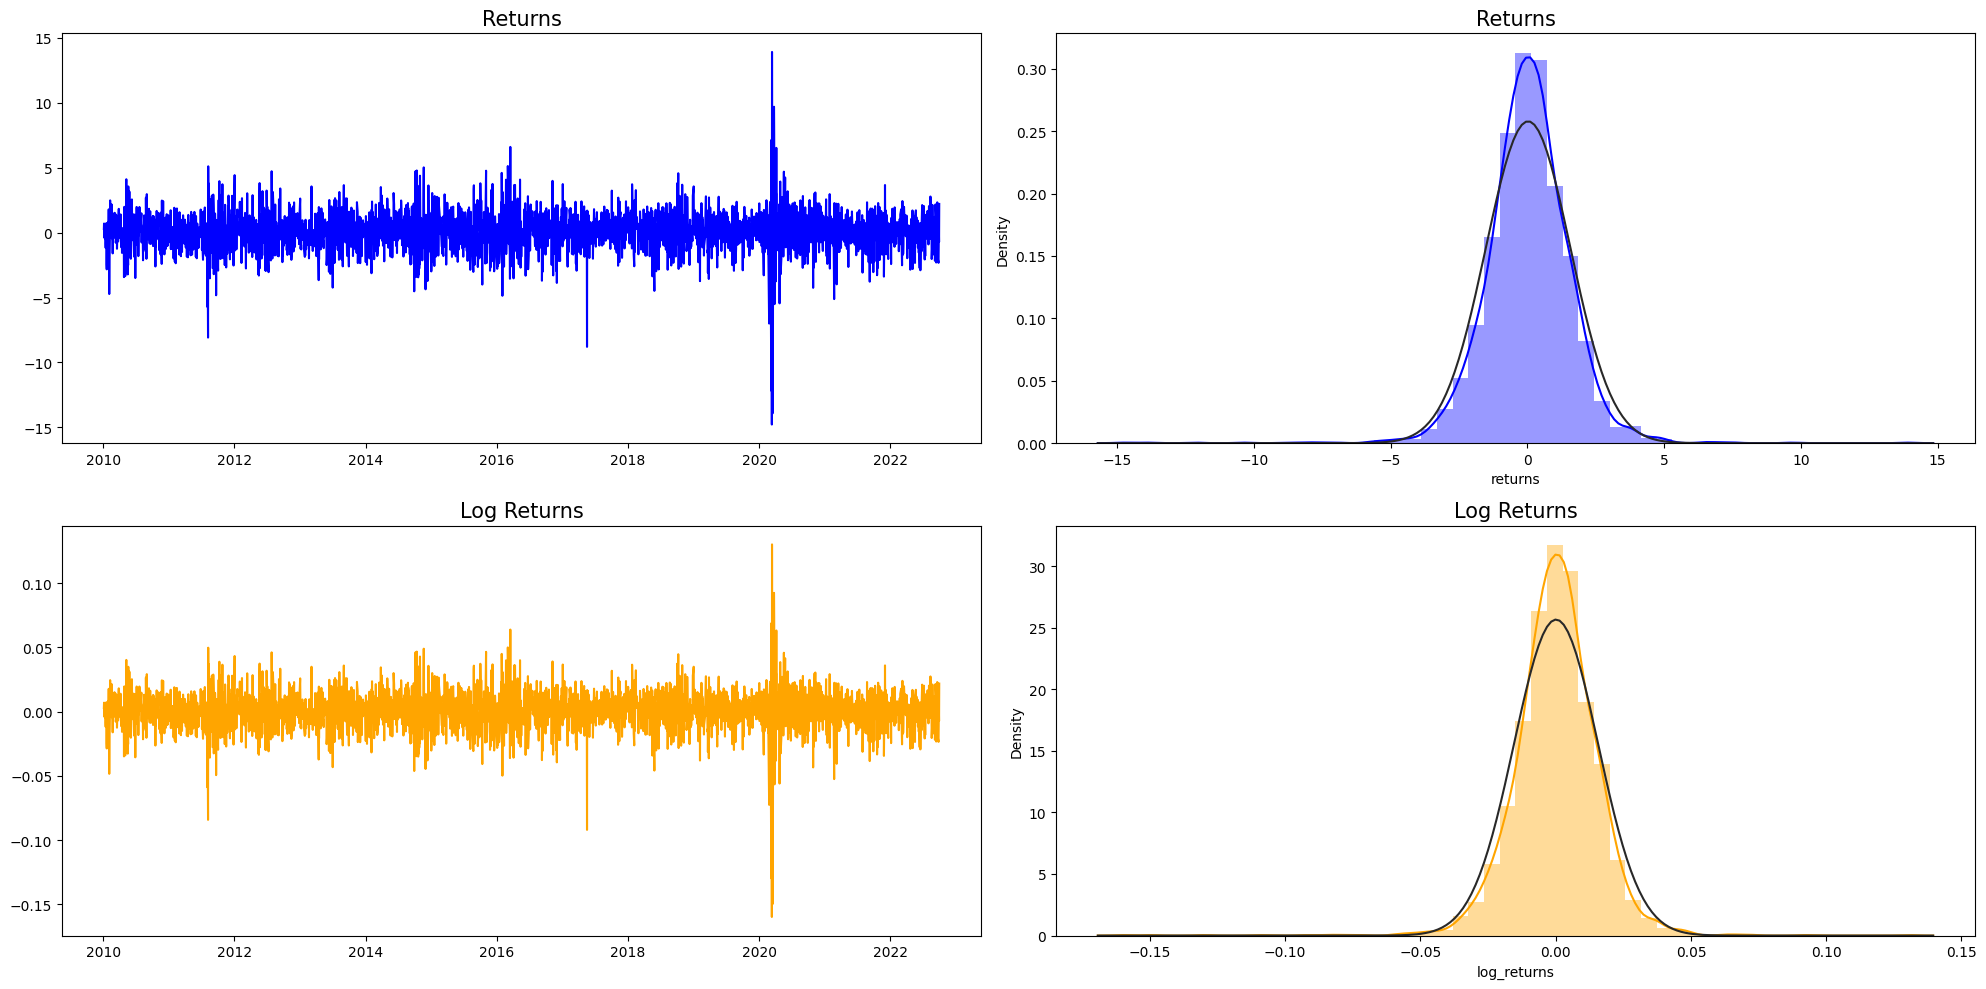

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

axes[0][0].plot(df['returns'], color='blue')
axes[0][0].set_title('Returns', fontsize=15)

sns.distplot(df['returns'], norm_hist=True, fit=stats.norm, color='blue',
             bins=50, ax=axes[0][1])
axes[0][1].set_title('Returns', fontsize=15)

axes[1][0].plot(df['log_returns'], color='orange')
axes[1][0].set_title('Log Returns', fontsize=15)

sns.distplot(df['log_returns'], norm_hist=True, fit=stats.norm, color='orange',
             bins=50, ax=axes[1][1])
axes[1][1].set_title('Log Returns', fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'returns.jpg'), dpi=300, bbox_inches='tight')
fig.show();

In [16]:
df['returns'].describe()

count    3154.000000
mean        0.026362
std         1.546882
min       -14.779679
25%        -0.816129
50%         0.032498
75%         0.892299
max        13.908215
Name: returns, dtype: float64

In [17]:
df['log_returns'].describe()

count    3154.000000
mean        0.000143
std         0.015550
min        -0.159930
25%        -0.008195
50%         0.000325
75%         0.008883
max         0.130223
Name: log_returns, dtype: float64

#### **Returns/Log Returns Estacionariedade**

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
adfuller_results = adfuller(df['log_returns'])

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -20.65001016287606
p-value: 0.0
Critical Values:
1%: -3.4324
5%: -2.8625
10%: -2.5673


In [20]:
# RETURNS
adfuller_results = adfuller(df['returns'])

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -20.948289628147638
p-value: 0.0
Critical Values:
1%: -3.4324
5%: -2.8625
10%: -2.5673


Para o nível de significancia com alpha igual a 0.05, o `p-value` de ambos, tanto o Retorno quanto do Log Retorno são menores que o alpha, logo tem-se evidencia suficiente para rejeitar a Hipotese nula.

### Verificar Autocorrelação e Autocorrelação Parcial

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

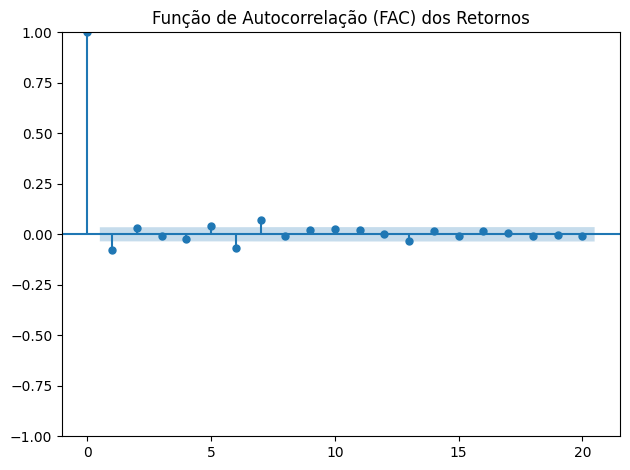

In [22]:
plot_acf(df['returns'], lags=20,  title="Função de Autocorrelação (FAC) dos Retornos");
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'fac-return.jpg'), dpi=300, bbox_inches='tight')

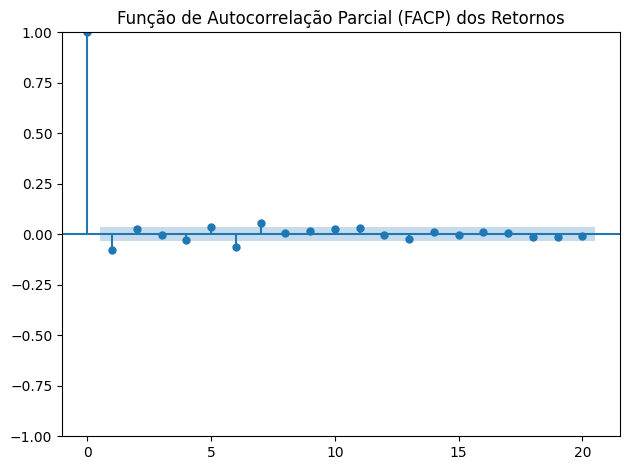

In [23]:
plot_pacf(df['returns'], lags=20, title="Função de Autocorrelação Parcial (FACP) dos Retornos");
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'facp-return.jpg'), dpi=300, bbox_inches='tight')

In [24]:
acorr_ljungbox(df['returns'], lags=10)

,lb_stat,lb_pvalue
1,20.063347,7.491883e-06
2,23.632057,7.385231e-06
3,23.937127,2.574646e-05
4,25.960226,3.223437e-05
5,30.889866,9.848124e-06
6,45.582734,3.584351e-08
7,60.864062,1.014434e-10
8,61.087343,2.850838e-10
9,62.563305,4.286753e-10
10,64.379017,5.327494e-10


In [25]:
# Calcular a volatilidade realizada diaria
def realized_volatility_daily(series_log_return):
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))
    # return np.sqrt(np.sum(series_log_return**2))

In [26]:
INTERVAL_WINDOW = 14
n_future = 14

# df['vol_current'] = df['log_returns'].apply(realized_volatility_daily)
# Volatilidade realizada
# df['vol_current'] = df['log_returns']\
#   .rolling(window=INTERVAL_WINDOW)\
#     .apply(realized_volatility_daily)

# df['vol_future'] = df['log_returns']\
#   .shift(-n_future)\
#     .rolling(window=INTERVAL_WINDOW)\
#       .apply(realized_volatility_daily)

df['vol_current'] = df['log_returns']\
  .rolling(window=INTERVAL_WINDOW)\
    .apply(realized_volatility_daily)

df['vol_future'] = df['log_returns']\
    .rolling(window=INTERVAL_WINDOW)\
      .apply(realized_volatility_daily)

In [27]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,log_returns,vol_current,vol_future
Date,,,,,,,,,,,
2010-01-05 00:00:00-02:00,70046.0,70595.0,69928.0,70240.0,1984200,0,0,0.278392,0.002780,NaN,NaN
2010-01-06 00:00:00-02:00,70237.0,70937.0,70016.0,70729.0,2243600,0,0,0.696185,0.006938,NaN,NaN
2010-01-07 00:00:00-02:00,70723.0,70723.0,70045.0,70451.0,1555000,0,0,-0.393050,-0.003938,NaN,NaN
2010-01-08 00:00:00-02:00,70455.0,70766.0,70158.0,70263.0,1634400,0,0,-0.266852,-0.002672,NaN,NaN
2010-01-11 00:00:00-02:00,70267.0,71068.0,70158.0,70433.0,1569000,0,0,0.241948,0.002417,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26 00:00:00-03:00,111713.0,111713.0,109022.0,109114.0,13127000,0,0,-2.329120,-0.023567,0.016637,0.016637
2022-09-27 00:00:00-03:00,109122.0,110161.0,108120.0,108376.0,14517500,0,0,-0.676357,-0.006787,0.015594,0.015594
2022-09-28 00:00:00-03:00,108377.0,108970.0,107914.0,108451.0,13540500,0,0,0.069204,0.000692,0.015590,0.015590


In [28]:
df.dropna(inplace=True)

Text(0, 0.5, 'Preço Fechamento')

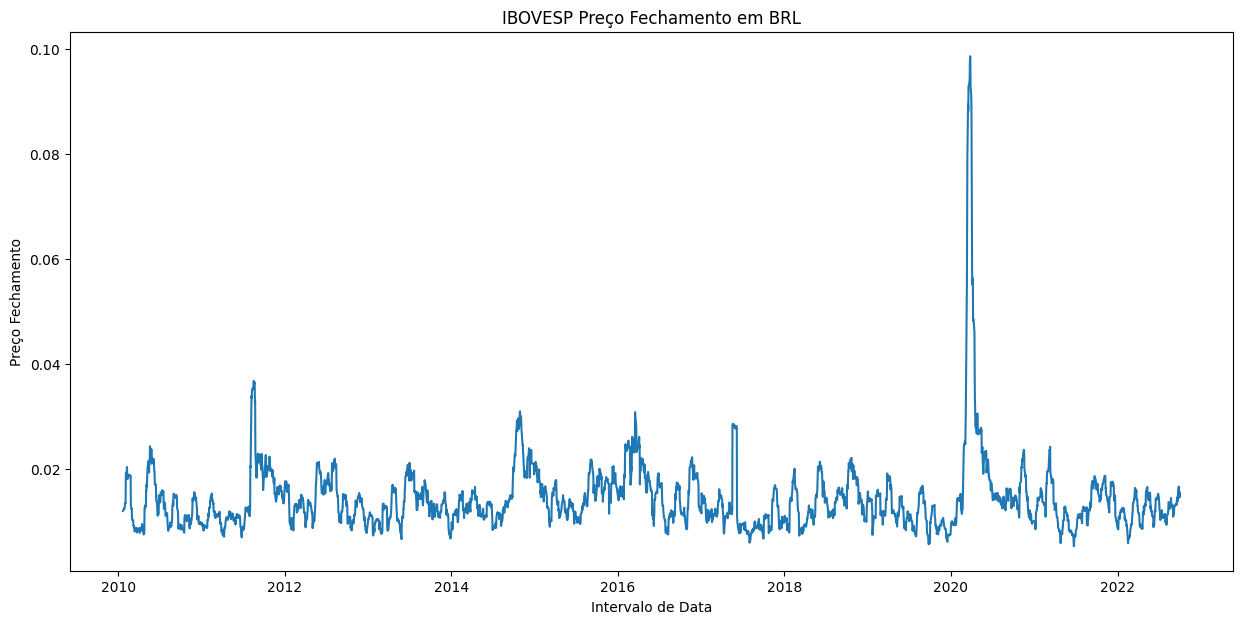

In [29]:
plt.figure(figsize=(15,7))
plt.title('IBOVESP Preço Fechamento em BRL')
plt.plot(df['vol_current'])
plt.xlabel('Intervalo de Data')
plt.ylabel('Preço Fechamento')

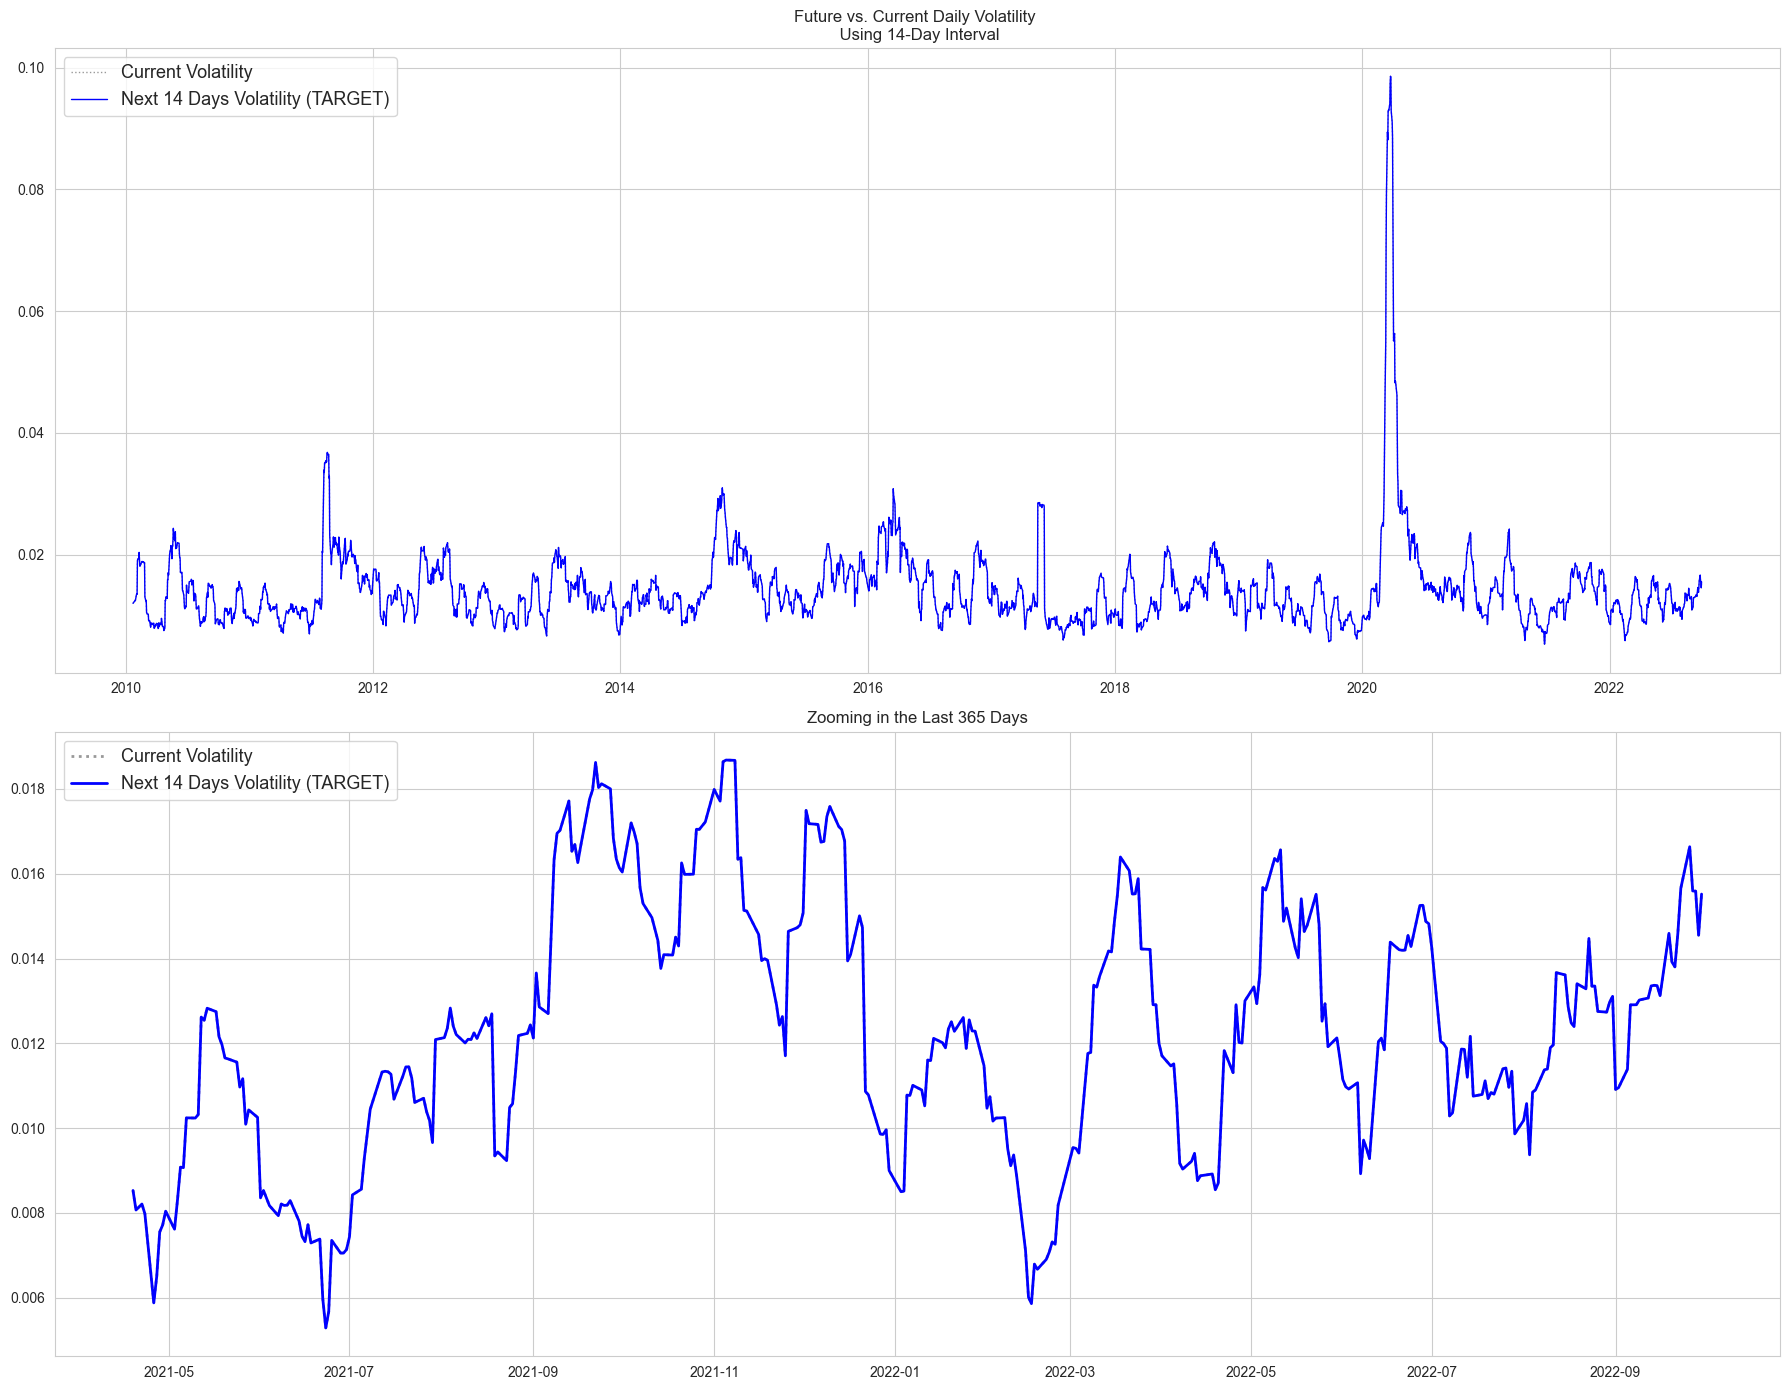

In [30]:
n_zoom = 365

# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df["vol_current"], alpha=.8, lw=1, color='gray', ls=':',
            label='Current Volatility')
    ax1.plot(df["vol_future"], lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax2.plot(df["vol_current"][-n_zoom:], alpha=.8, lw=2, color='gray', ls=':',
            label='Current Volatility')
    ax2.plot(df["vol_future"][-n_zoom:], lw=2, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax1.title.set_text(f'Future vs. Current Daily Volatility \n Using {INTERVAL_WINDOW}-Day Interval')
    ax2.title.set_text(f'Zooming in the Last {n_zoom} Days')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.tight_layout()
    plt.savefig(os.path.join(img_dir, 'daily_vol.jpg'), 
                dpi=300, bbox_inches='tight')
    plt.show();

### Treino - Teste - Validação 

O dataset será dividido em:
- Os 30 itens finais serão utilizados para teste final.
- 1 ano inteiro para validação e ajustes do modelo
- E o restante para treinamento

In [31]:
test_size = 30
val_size = 365

# INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# PARA DIVIDIR O DATASET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [32]:
print(f'Training \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'Validation \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'Test \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

Training 	From: 2010-01-22 00:00:00-02:00 	to: 2021-03-04 00:00:00-03:00 	2746 days
Validation 	From: 2021-03-05 00:00:00-03:00 	to: 2022-08-18 00:00:00-03:00 	365 days
Test 		From: 2022-08-19 00:00:00-03:00 	to: 2022-09-30 00:00:00-03:00 	30 days


In [33]:
y_train = df['vol_future'][train_idx]
y_val = df['vol_future'][val_idx]
y_test = df['vol_future'][test_idx]

In [34]:
x_train = df['vol_current'][train_idx]
x_val = df['vol_current'][val_idx]
x_test = df['vol_current'][test_idx]

In [35]:
r_train = df['returns'][train_idx]
r_val = df['returns'][val_idx]
r_test = df['returns'][test_idx]

In [36]:
lr_train = df['log_returns'][train_idx]
lr_val = df['log_returns'][val_idx]
lr_test = df['log_returns'][test_idx]

### Normalizar os dados

In [37]:
def transform_volatility_to_scaler(scaler, tf_series):
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [38]:
scaler_vol = StandardScaler()
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [39]:
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

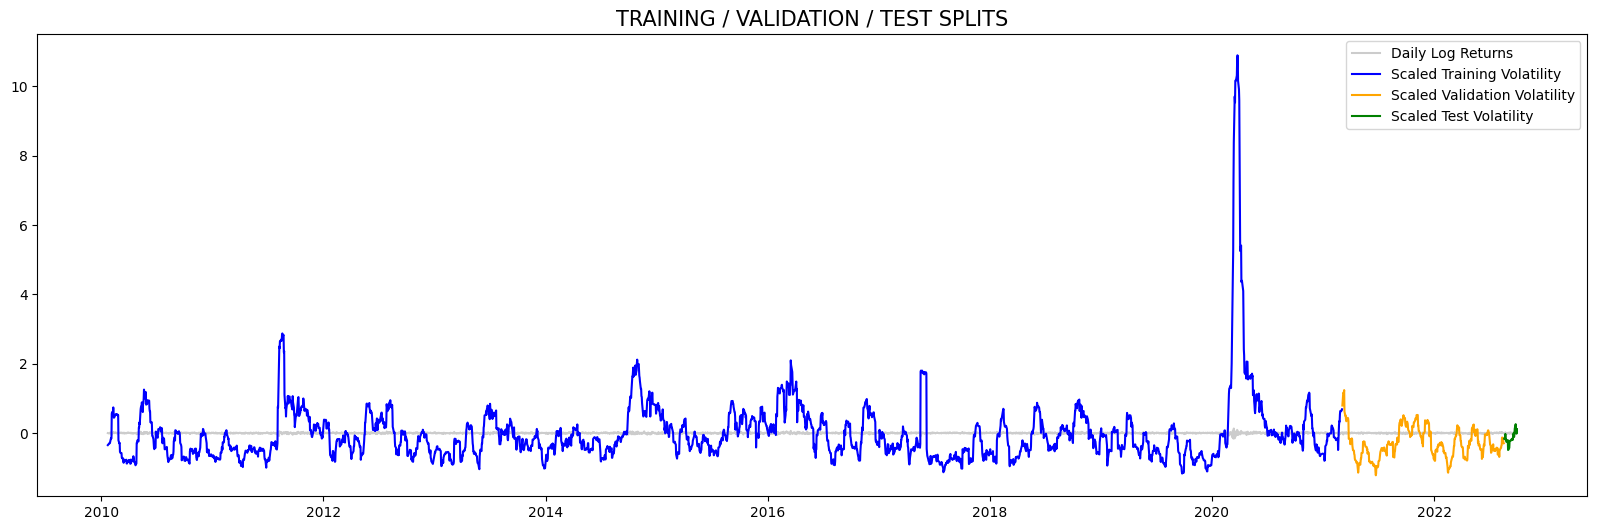

In [40]:
plt.figure(figsize=(20,6))

plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

plt.plot(x_train_scaled, color='blue', label='Scaled Training Volatility')
plt.plot(x_val_scaled, color='orange', label='Scaled Validation Volatility')
plt.plot(x_test_scaled, color='green', label='Scaled Test Volatility')

plt.plot()
plt.title(f'TRAINING / VALIDATION / TEST SPLITS', 
          fontsize=15)
plt.legend(frameon=True)
plt.savefig(os.path.join(img_dir, 'train_val_test.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [41]:
def correlogram(x, lags, title):
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0],grid= True, color='red')
    q_p = np.max(q_stat(acf(x,lags), len(x))[1])
    stats= f'ADF:{adfuller(x)[1]:.2f},\nQ-Stat:{q_p:.2f}'
    axes[0][0].text(x=.03, y=.85,s=stats, transform=axes[0][0].transAxes)
    
    #probability plot 
    probplot(x, plot=axes[0][1])
    mean, variance, skewness, kurtosis = moment(x, moment=[1, 2, 3, 4])
    stats1 = f'Mean: {mean:.2f}\nSD: {np.sqrt(variance):.2f}\nSkew: {skewness:.2f}\nKurtosis:{kurtosis:.2f}'
    axes[0][1].text(x=.02, y=.75,s=stats1, transform=axes[0][1].transAxes)
    
    #ACF and PACF plots
    plot_acf(x, lags=lags, zero=False, ax=axes[1][0],alpha=0.05,)
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)
    



In [42]:
def RMSPE(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

In [43]:
def RMSE(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [44]:
from sklearn.metrics import mean_absolute_percentage_error

def MAPE(y_true, y_pred): 
    return mean_absolute_percentage_error(y_true, y_pred)

In [129]:
def get_resid_garch(model):
    gm_resid = model.resid
    gm_std = model.conditional_volatility
    return gm_resid / gm_std

In [130]:
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE', "MAPE"])

In [131]:
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [
        model_name, 
        RMSPE(y_true, y_pred), 
         RMSE(y_true, y_pred), 
         MAPE(y_true, y_pred)
    ]
    return perf_df

In [132]:
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

In [133]:
analysis_df = pd.DataFrame(columns=['Model', 'AIC', 'BIC', 'LB', 'LB(r²)', 'ARCH', 'SW'])

In [134]:
def log_garch(model, model_name):
    analysis_df.loc[len(perf_df.index)] = [
        model_name, 
        model.aic,
        model.bic,
        acorr_ljungbox(get_resid_garch(model), lags=[10]),
        acorr_ljungbox(get_resid_garch(model)**2, lags=[10]),
        het_arch(get_resid_garch(model)),
        shapiro(get_resid_garch(model))
    ]
    return analysis_df

### GARCH MODELS

some Util links
- https://www.oreilly.com/library/view/machine-learning-for/9781492085249/ch04.html
- https://users.metu.edu.tr/home402/ozancan/wwwhome/ARCHGARCHTutorial.html
- https://bibliotecadigital.fgv.br/dspace/bitstream/handle/10438/10014/TD%20313%20-%20CEQEF%2003%20-%20Marcos%20Vinicio%20Wink%20Junior%20e%20%20Pedro%20Valls.pdf?sequence=1
- https://repositorio.ufc.br/bitstream/riufc/39729/1/2018_tcc_wlalves.pdf
- file:///C:/Users/Gabriel/Downloads/paulo%20thomaz.pdf

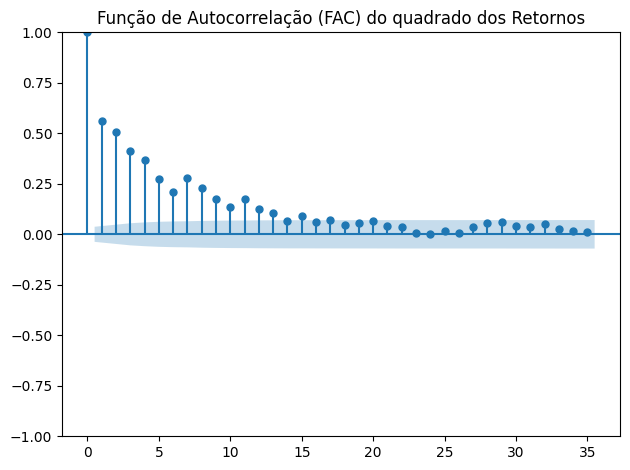

In [48]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2, 
          title='Função de Autocorrelação (FAC) do quadrado dos Retornos');
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'fac-return-squared.jpg'), dpi=300, bbox_inches='tight')

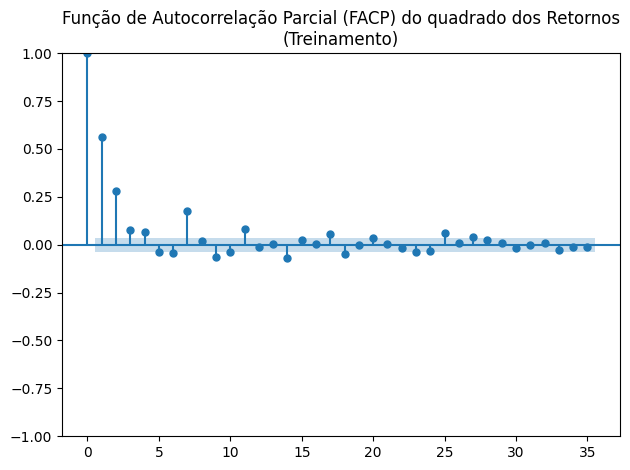

In [49]:
# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2, 
          title='Função de Autocorrelação Parcial (FACP) do quadrado dos Retornos\n(Treinamento)');
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'facp-return-squared.jpg'), dpi=300, bbox_inches='tight')

Verifica-se pelo quadrado dos retornos que o modelo ARCH é adaquado

In [50]:
acorr_ljungbox(r_train, lags=[10])

,lb_stat,lb_pvalue
10,67.420204,1.392335e-10


Como há autocorrelação significativa nos retornos da serie, uma vez que p < 0.005, logo, é necessário aplicação de um modelo ARMA, antes do modelo GARCH

In [51]:
from pmdarima.arima import auto_arima

In [52]:
arma = auto_arima(
  r_train,
  d=0,
  max_q=12,
  max_p=12,
  trace=True,
  seasonal=False,
  error_action='ignore',
  suppress_warnings=True,
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=10296.285, Time=0.88 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10334.972, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=10317.904, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10319.093, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=10318.898, Time=0.44 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=10319.260, Time=0.30 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=10298.045, Time=1.68 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=10298.022, Time=1.22 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=10317.761, Time=0.22 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=10320.449, Time=0.49 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=10320.827, Time=0.70 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=10298.465, Time=1.85 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=10297.037, Time=1.68 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 9.729 seconds


In [53]:
resid_arma = arma.resid()

In [54]:
acorr_ljungbox(resid_arma, lags=[10])

,lb_stat,lb_pvalue
10,7.989887,0.629825


Logo o modelo ARMA (2,2) é possível remover autocorrelação significativa da serie de retornos.

In [55]:
hetarch_results =   (resid_arma)

print(f'Lagrange statistic: {hetarch_results[0]}')
print(f'p-value: {hetarch_results[1]}')

Lagrange statistic: -0.07544892108042323
p-value: -1.0576806348322783


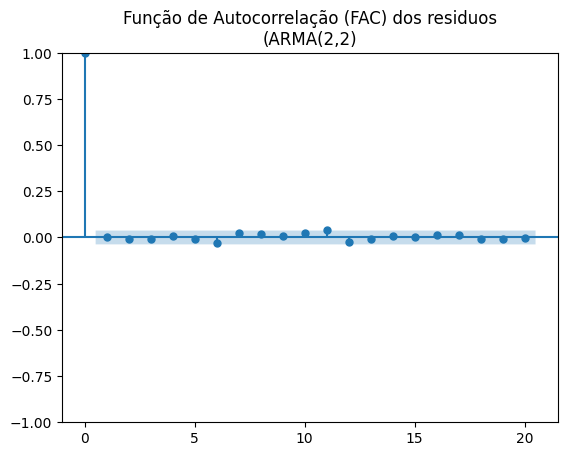

In [56]:
plot_acf(resid_arma,  lags=20,
          title='Função de Autocorrelação (FAC) dos residuos\n(ARMA(2,2)');

Pelo teste ARCH, p-value indica que existe presença de heteroscedasticidade significativa nos resíduos do modelo ARMA

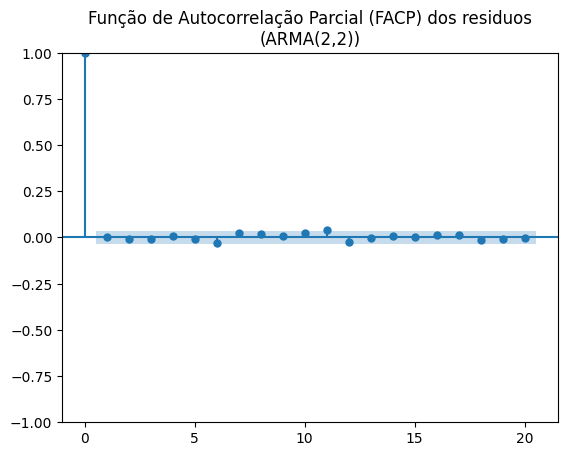

In [57]:
plot_pacf(resid_arma, lags=20,
          title='Função de Autocorrelação Parcial (FACP) dos residuos\n(ARMA(2,2))');

evidenciam que a autocorrelação nos resíduos foi eliminada, com apenas um pico de autocorrelação na primeira defasagem

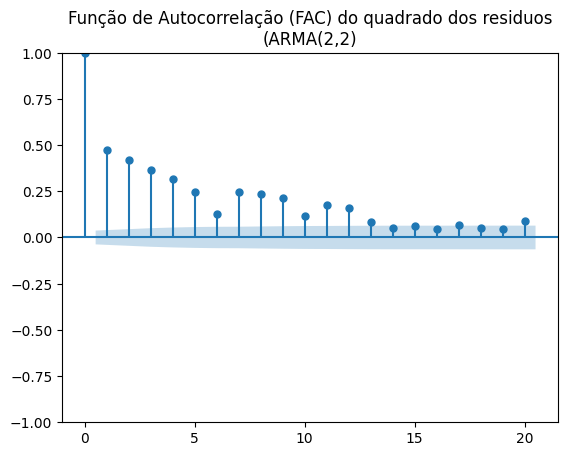

In [58]:
plot_acf(resid_arma**2,  lags=20,
          title='Função de Autocorrelação (FAC) do quadrado dos residuos\n(ARMA(2,2)');

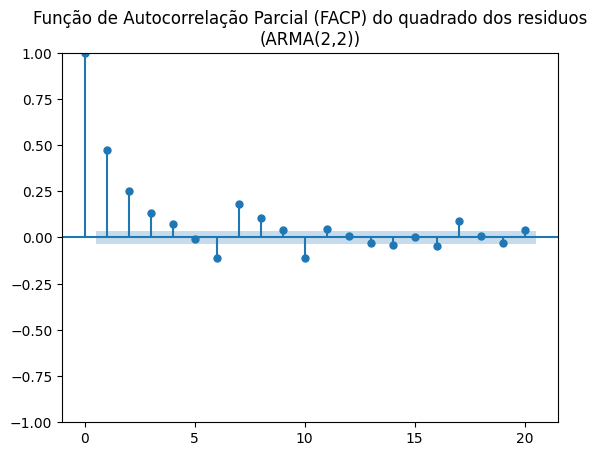

In [59]:
plot_pacf(resid_arma**2, lags=20,
          title='Função de Autocorrelação Parcial (FACP) do quadrado dos residuos\n(ARMA(2,2))');

Os resíduos ao quadrado, nota-se que existe presença de heteroscedasticidade condicional, sendo que esta permanece até defasagens elevadas, o que indica alta persistência na volatilidade.

In [60]:
from arch import arch_model

In [61]:
gm_22 = arch_model(r_train, p=2, q=2)
result_22 = gm_22.fit(disp='off')
print()
print(result_22.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4847.43
Distribution:                  Normal   AIC:                           9706.86
Method:            Maximum Likelihood   BIC:                           9742.37
                                        No. Observations:                 2746
Date:                Thu, Nov 24 2022   Df Residuals:                     2745
Time:                        21:46:52   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0584  2.622e-02      2.228  2.591e-02 [7.016e-

Utilizando nivel de significande de 0.05, nenhum dos coefieficientes parecem ser estatisticamente significante, já que o os seus p-values `P > |t|` são todos maiores que 0.05. Vou reduzir o `p` e `q` para 1 para ver se melhora

In [62]:
gm_11 = arch_model(r_train, p=1, q=1)
result_11 = gm_11.fit(disp='off')
print()
print(result_11.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4851.05
Distribution:                  Normal   AIC:                           9710.10
Method:            Maximum Likelihood   BIC:                           9733.77
                                        No. Observations:                 2746
Date:                Thu, Nov 24 2022   Df Residuals:                     2745
Time:                        21:46:52   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0577  2.597e-02      2.223  2.621e-02 [6.832e-

Todos parecem ser estatisticamente significante agora.
Vou testar mais alguns outros hiperparametros, e escolher o modelo que possui menor AIC e BIC

In [63]:
gm_21 = arch_model(r_train, p=2, q=1)
result_21 = gm_21.fit(disp='off')
print()
print(result_21.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4850.46
Distribution:                  Normal   AIC:                           9710.92
Method:            Maximum Likelihood   BIC:                           9740.51
                                        No. Observations:                 2746
Date:                Thu, Nov 24 2022   Df Residuals:                     2745
Time:                        21:46:52   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0577  2.617e-02      2.203  2.758e-02 [6.368e-

In [64]:
gm_12 = arch_model(r_train, p=1, q=2)
result_12 = gm_12.fit(disp='off')
print()
print(result_12.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4851.05
Distribution:                  Normal   AIC:                           9712.10
Method:            Maximum Likelihood   BIC:                           9741.69
                                        No. Observations:                 2746
Date:                Thu, Nov 24 2022   Df Residuals:                     2745
Time:                        21:46:52   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0577  2.597e-02      2.222  2.625e-02 [6.818e-

In [65]:
shapiro_results_11 = shapiro(result_11.resid)
print("GARCH(1,1)")
print(f'Statistic: {shapiro_results_11[0]}')
print(f'p-value: {shapiro_results_11[1]}')

shapiro_results_12 = shapiro(result_12.resid)
print("GARCH(1,2)")
print(f'Statistic: {shapiro_results_12[0]}')
print(f'p-value: {shapiro_results_12[1]}')

shapiro_results_22 = shapiro(result_22.resid)
print("GARCH(2,2)")
print(f'Statistic: {shapiro_results_22[0]}')
print(f'p-value: {shapiro_results_22[1]}')

shapiro_results_21 = shapiro(result_21.resid)
print("GARCH(2,1)")
print(f'Statistic: {shapiro_results_21[0]}')
print(f'p-value: {shapiro_results_21[1]}')

GARCH(1,1)
Statistic: 0.9285213351249695
p-value: 2.45347527864697e-34
GARCH(1,2)
Statistic: 0.9285213351249695
p-value: 2.45347527864697e-34
GARCH(2,2)
Statistic: 0.9285213351249695
p-value: 2.45347527864697e-34
GARCH(2,1)
Statistic: 0.9285213351249695
p-value: 2.45347527864697e-34


Nenhum modelo foi capaz de possuir seus residuos seguindo a distribuição normal, mas é comum para series financeira, porém a lib permite setar a distribuição `dist` como `t` para Student's T
Vale ressaltar que apenas modelos com parametros com `p` e `q` com valores `1,1` e `1,2` apresentaram ser estatisticamente significante.


In [66]:
def getStdResidGarchModel(model):
    # INSPECTING THE RESIDUALS
    gm_resid = model.resid
    gm_std = model.conditional_volatility
    # STANDARDIZING RESIDUALS
    return gm_resid / gm_std

In [67]:
shapiro_results_11 = shapiro(getStdResidGarchModel(result_11))
print("GARCH(1,1)")
print(f'Statistic: {shapiro_results_11[0]}')
print(f'p-value: {shapiro_results_11[1]}')

shapiro_results_12 = shapiro(getStdResidGarchModel(result_12))
print("GARCH(1,2)")
print(f'Statistic: {shapiro_results_12[0]}')
print(f'p-value: {shapiro_results_12[1]}')

shapiro_results_22 = shapiro(getStdResidGarchModel(result_22))
print("GARCH(2,2)")
print(f'Statistic: {shapiro_results_22[0]}')
print(f'p-value: {shapiro_results_22[1]}')

shapiro_results_21 = shapiro(getStdResidGarchModel(result_21))
print("GARCH(2,1)")
print(f'Statistic: {shapiro_results_21[0]}')
print(f'p-value: {shapiro_results_21[1]}')

GARCH(1,1)
Statistic: 0.9882773756980896
p-value: 2.918685462044955e-14
GARCH(1,2)
Statistic: 0.9882767796516418
p-value: 2.915921762944654e-14
GARCH(2,2)
Statistic: 0.9884234070777893
p-value: 3.7324127350000375e-14
GARCH(2,1)
Statistic: 0.9880882501602173
p-value: 2.129094731735063e-14


In [68]:
acorr_ljungbox(getStdResidGarchModel(result_11), lags=[10])

,lb_stat,lb_pvalue
10,8.383554,0.591426


In [69]:
het_arch(getStdResidGarchModel(result_11))

(8.201189904252796, 0.6091922005309537, 0.8192775217283729, 0.6100415508481705)

In [70]:
acorr_ljungbox(getStdResidGarchModel(result_11)**2, lags=[10])

,lb_stat,lb_pvalue
10,7.860421,0.642469


In [71]:
gm_student_11 = arch_model(r_train, p=1, q=1, dist="StudentsT")
result_student_11 = gm_student_11.fit(disp='off')
print()
print(result_student_11.summary())


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -4812.72
Distribution:      Standardized Student's t   AIC:                           9635.44
Method:                  Maximum Likelihood   BIC:                           9665.03
                                              No. Observations:                 2746
Date:                      Thu, Nov 24 2022   Df Residuals:                     2745
Time:                              21:46:53   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu       

In [72]:
gm_student_22 = arch_model(r_train, p=2, q=2, dist="StudentsT")
result_student_22 = gm_student_22.fit(disp='off')
print()
print(result_student_22.summary())


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -4809.83
Distribution:      Standardized Student's t   AIC:                           9633.66
Method:                  Maximum Likelihood   BIC:                           9675.09
                                              No. Observations:                 2746
Date:                      Thu, Nov 24 2022   Df Residuals:                     2745
Time:                              21:46:53   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu       

In [73]:
gm_student_12 = arch_model(r_train, p=1, q=2, dist="StudentsT")
result_student_12 = gm_student_12.fit(disp='off')
print()
print(result_student_12.summary())


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -4812.72
Distribution:      Standardized Student's t   AIC:                           9637.44
Method:                  Maximum Likelihood   BIC:                           9672.95
                                              No. Observations:                 2746
Date:                      Thu, Nov 24 2022   Df Residuals:                     2745
Time:                              21:46:53   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu       

In [74]:
gm_student_21 = arch_model(r_train, p=2, q=1, dist="StudentsT")
result_student_21 = gm_student_21.fit(disp='off')
print()
print(result_student_21.summary())


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -4811.62
Distribution:      Standardized Student's t   AIC:                           9635.24
Method:                  Maximum Likelihood   BIC:                           9670.75
                                              No. Observations:                 2746
Date:                      Thu, Nov 24 2022   Df Residuals:                     2745
Time:                              21:46:53   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu       

Nenhum modelo GARCH com distribuição T Student apresentou parametros estatisticamente significante

Os modelos de previsão GARCH contém um atributo chamado de volitidade condicional, o qual vou transformá-lo e compará-lo com a volatilidade realizada que foi calculada

In [75]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility 
    Estimated by GARCH Models
    '''
    cond_vol = model_result.conditional_volatility
    scaler = StandardScaler()
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))
    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [76]:
scaler_garch_11, scaled_cond_vol_11 = scale_tf_cond_vol(result_11)

In [77]:
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

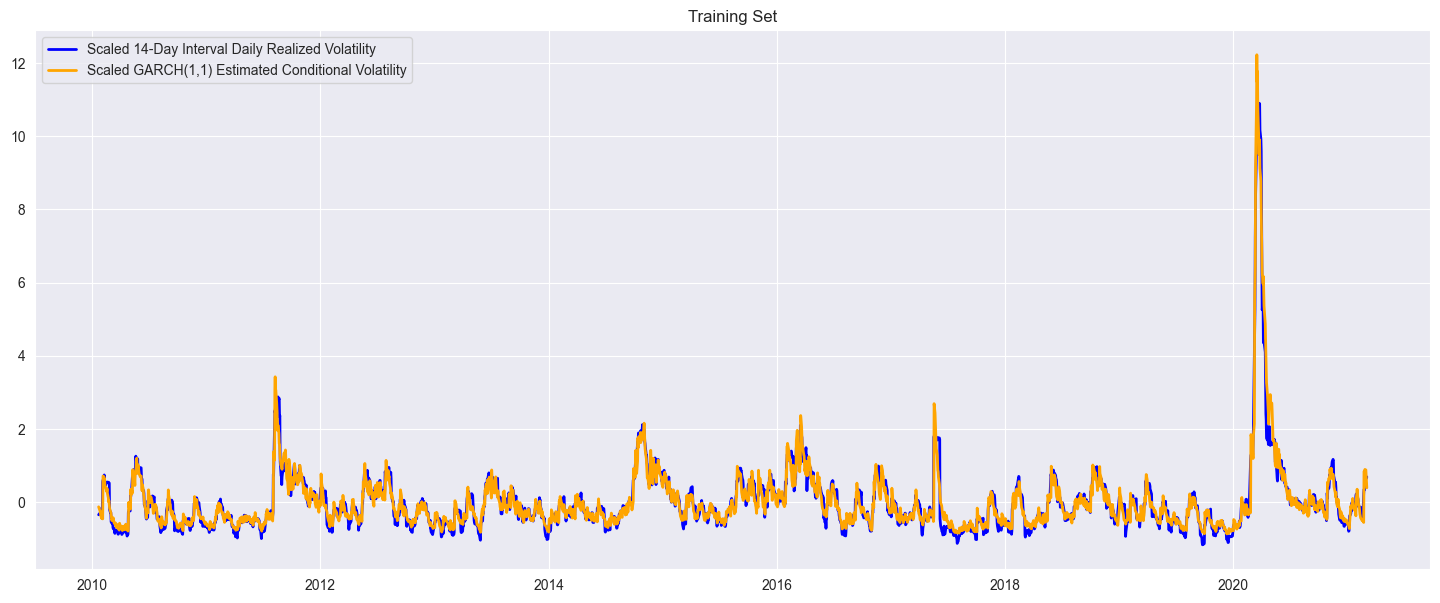

In [78]:
viz_cond_vol(scaled_cond_vol_11, 'GARCH(1,1)')

### Expanding Window Forecasting

Será dada a previsão para os próximo dias futuros `n_future = 7` e assim deve-se reajustar o modelo para cada passo no tempo.


In [79]:
# EXPANDING WINDOW FORECAST
size = len(val_idx)
rolling_forecasts = []
idx = df.index

# Set de validação
for i in range(0, size, n_future):
    # Pegar os valores anteriores a esse step
    idx = val_idx[i]
    train = df.returns[:idx]
    
    # treinar o modelo até esse step
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # fazer a predição com n_future 
    values = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.iloc[0]
    
    for value in values:
        rolling_forecasts.append(value)

In [80]:
values_forecast = []
for i in range(size):
    values_forecast.append(rolling_forecasts[i]**.5)

gm_1_preds = pd.Series(values_forecast, index=val_idx)


In [81]:
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch_11, gm_1_preds)

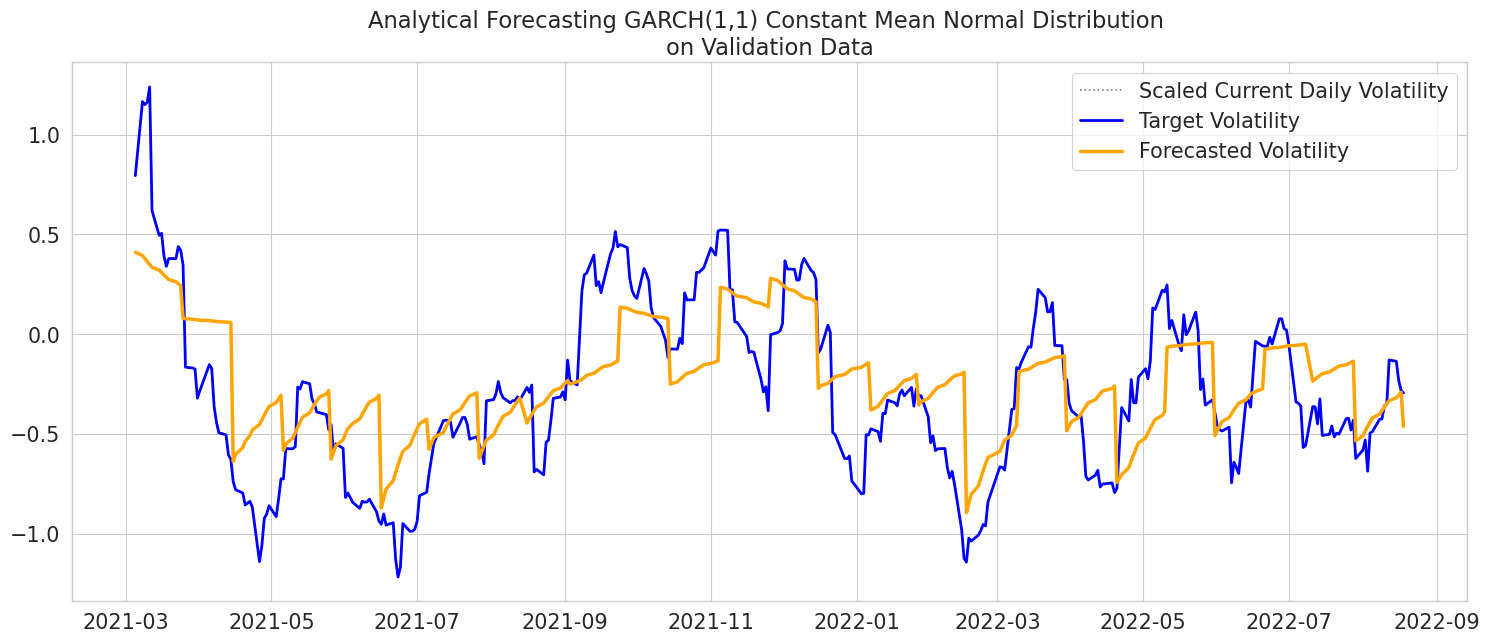

In [82]:
viz_model(y_val_scaled, gm_1_preds_scaled, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

In [83]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled, 
         'GARCH(1,1), Constant Mean, Normal Dist')

,Model,Validation RMSPE,Validation RMSE,MAPE
0,"GARCH(1,1), Constant Mean, Normal Dist",6.293063,0.31033,1.420935


### Garch Model with asymmetric shock response

In [84]:
gjr_gm_11 = arch_model(
  r_train, 
  p=1, 
  q=1, 
  o=1, 
  vol='GARCH', 
  dist='skewt'
)
result_gjr_gm_11 = gjr_gm_11.fit(disp='off')
print(result_gjr_gm_11.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -4794.27
Distribution:      Standardized Skew Student's t   AIC:                           9602.54
Method:                       Maximum Likelihood   BIC:                           9643.97
                                                   No. Observations:                 2746
Date:                           Thu, Nov 24 2022   Df Residuals:                     2745
Time:                                   21:46:56   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

In [123]:
result_gjr_gm_11

9602.539870849974

In [85]:
gjr_gm_22 = arch_model(
  r_train, 
  p=2, 
  q=2, 
  o=1, 
  dist='t'
)
result_gjr_gm_22 = gjr_gm_22.fit(disp='off')
print(result_gjr_gm_22.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -4793.22
Distribution:      Standardized Student's t   AIC:                           9602.43
Method:                  Maximum Likelihood   BIC:                           9649.78
                                              No. Observations:                 2746
Date:                      Thu, Nov 24 2022   Df Residuals:                     2745
Time:                              21:46:56   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [86]:
gjr_gm_21 = arch_model(
  r_train, 
  p=2, 
  q=1, 
  o=1, 
  vol='GARCH', 
  dist='skewt'
)
result_gjr_gm_21 = gjr_gm_21.fit(disp='off')
print(result_gjr_gm_21.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -4792.91
Distribution:      Standardized Skew Student's t   AIC:                           9601.83
Method:                       Maximum Likelihood   BIC:                           9649.17
                                                   No. Observations:                 2746
Date:                           Thu, Nov 24 2022   Df Residuals:                     2745
Time:                                   21:46:56   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

In [87]:
gjr_gm_12 = arch_model(
  r_train, 
  p=1, 
  q=2, 
  o=1, 
  vol='GARCH', 
  dist='skewt'
)
result_gjr_gm_12 = gjr_gm_12.fit(disp='off')
print(result_gjr_gm_12.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -4794.27
Distribution:      Standardized Skew Student's t   AIC:                           9604.54
Method:                       Maximum Likelihood   BIC:                           9651.88
                                                   No. Observations:                 2746
Date:                           Thu, Nov 24 2022   Df Residuals:                     2745
Time:                                   21:46:56   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

In [88]:
gjr_gm_22 = arch_model(
  r_train, 
  p=2, 
  q=2, 
  o=1, 
  vol='GARCH', 
  dist='skewt'
)
result_gjr_gm_22 = gjr_gm_22.fit(disp='off')
print(result_gjr_gm_22.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -4792.91
Distribution:      Standardized Skew Student's t   AIC:                           9603.83
Method:                       Maximum Likelihood   BIC:                           9657.09
                                                   No. Observations:                 2746
Date:                           Thu, Nov 24 2022   Df Residuals:                     2745
Time:                                   21:46:56   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

Veremos como se comporta para GJR-GARCH (1,1)

In [94]:
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_gjr_gm_11)

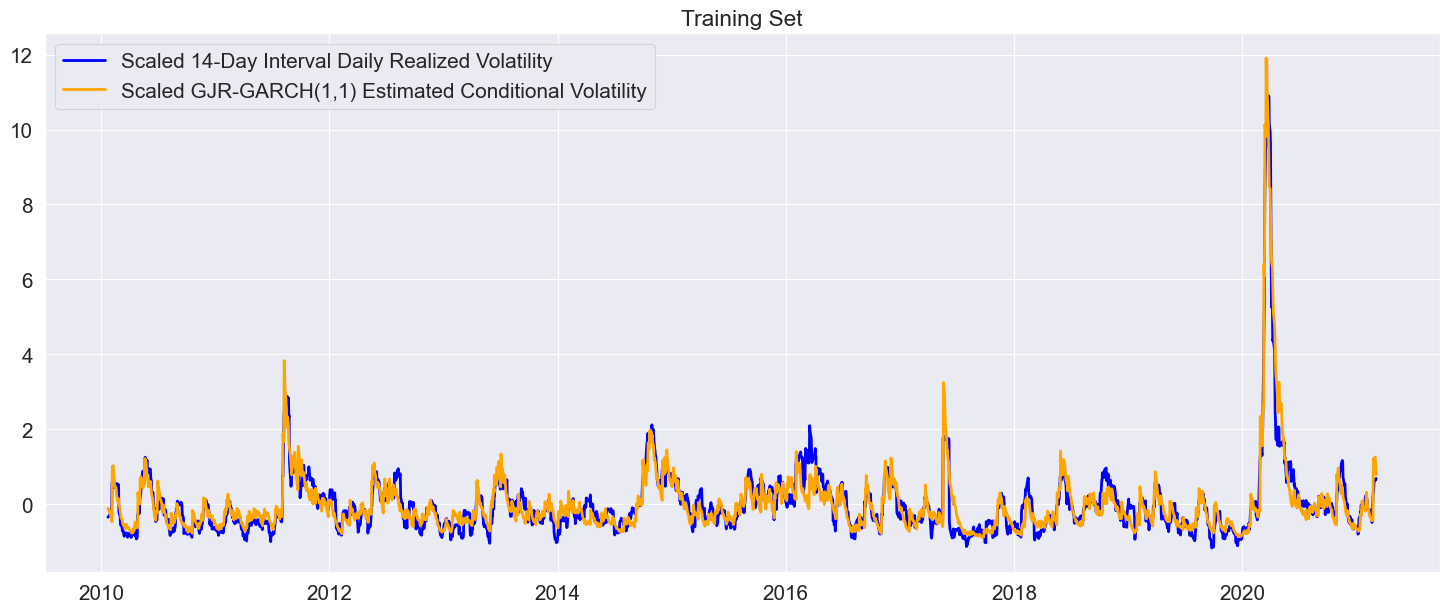

In [95]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [117]:
# EXPANDING WINDOW FORECAST
size = len(val_idx)
rolling_forecasts = []
idx = df.index

# Set de validação
for i in range(0, size):
    # Pegar os valores anteriores a esse step
    idx = val_idx[i]
    train = df.returns[:idx]
    
    # treinar o modelo até esse step
    model = arch_model(train, p=1, q=1, o=1, 
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # fazer a predição com n_future 
    values = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.iloc[0]
    
    for value in values:
        rolling_forecasts.append(value)

In [113]:
values_forecast = []
for i in range(size):
    values_forecast.append(rolling_forecasts[i]**.5)

gjr_1_preds = pd.Series(values_forecast, index=val_idx)


In [114]:
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

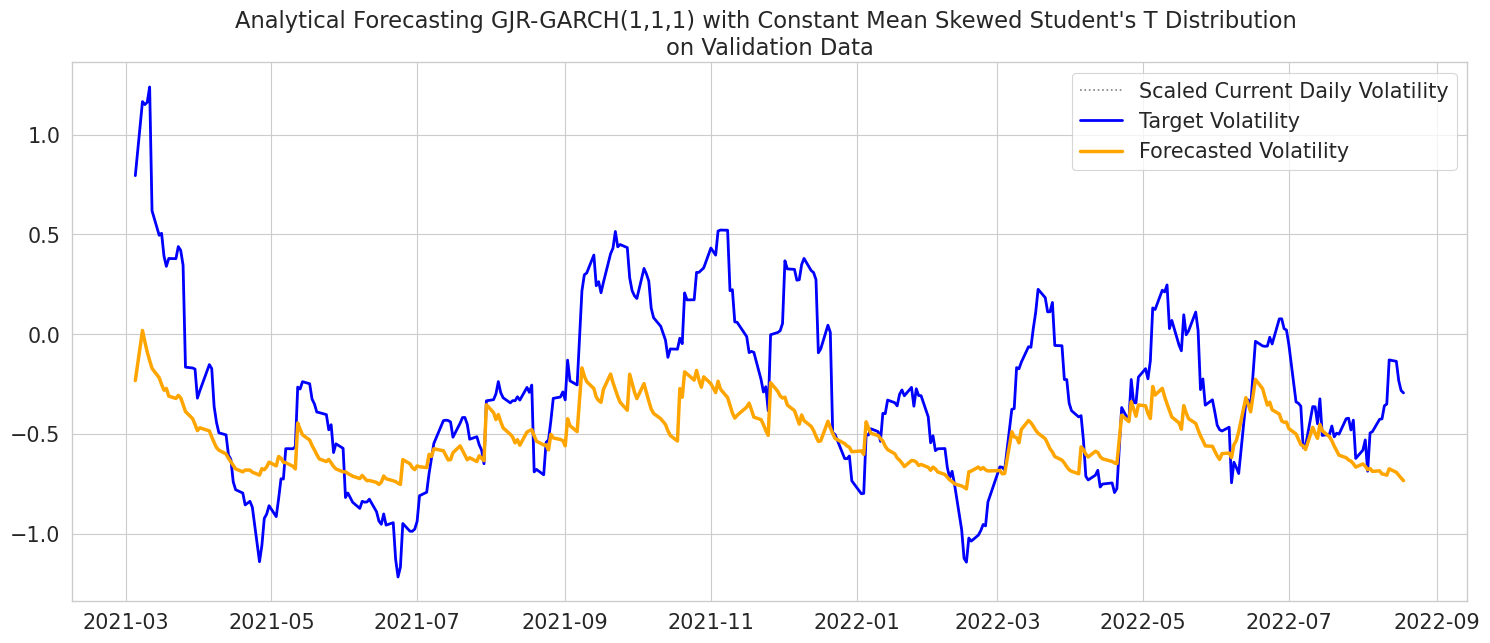

In [115]:
viz_model(y_val_scaled, gjr_1_preds_scaled, 
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")

In [116]:
log_perf(y_val_scaled, gjr_1_preds_scaled, 
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

,Model,Validation RMSPE,Validation RMSE,MAPE
0,"GARCH(1,1), Constant Mean, Normal Dist",6.293063,0.310330,1.420935
1,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",11.928362,0.328681,2.279889
2,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",7.804272,0.798903,2.494465
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",10.207057,0.388864,2.790443
4,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",9.927026,0.384349,2.755879


### TARCH

In [89]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm_11 = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='skewt')
result_gm_11 = t_gm_11.fit(disp='off')
print(result_gm_11.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -4793.57
Distribution:      Standardized Skew Student's t   AIC:                           9601.15
Method:                       Maximum Likelihood   BIC:                           9642.57
                                                   No. Observations:                 2746
Date:                           Thu, Nov 24 2022   Df Residuals:                     2745
Time:                                   21:46:57   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

In [90]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm_12 = arch_model(r_train, p=1, o=1, q=2, power=1.0,
                  dist='skewt')
result_gm_12 = t_gm_12.fit(disp='off')
print(result_gm_12.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -4793.57
Distribution:      Standardized Skew Student's t   AIC:                           9603.15
Method:                       Maximum Likelihood   BIC:                           9650.49
                                                   No. Observations:                 2746
Date:                           Thu, Nov 24 2022   Df Residuals:                     2745
Time:                                   21:46:57   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

In [91]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm_21 = arch_model(r_train, p=2, o=1, q=1, power=1.0,
                  dist='skewt')
result_gm_21 = t_gm_21.fit(disp='off')
print(result_gm_21.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -4791.82
Distribution:      Standardized Skew Student's t   AIC:                           9599.63
Method:                       Maximum Likelihood   BIC:                           9646.98
                                                   No. Observations:                 2746
Date:                           Thu, Nov 24 2022   Df Residuals:                     2745
Time:                                   21:46:57   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

In [92]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm_12 = arch_model(r_train, p=2, o=1, q=2, power=1.0,
                  dist='skewt')
result_gm_12 = t_gm_12.fit(disp='off')
print(result_gm_12.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -4791.78
Distribution:      Standardized Skew Student's t   AIC:                           9601.56
Method:                       Maximum Likelihood   BIC:                           9654.82
                                                   No. Observations:                 2746
Date:                           Thu, Nov 24 2022   Df Residuals:                     2745
Time:                                   21:46:57   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

In [93]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm_student_11 = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='t')
result_gm_student_11 = t_gm_student_11.fit(disp='off')
print(result_gm_student_11.summary())

                     Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -4794.02
Distribution:      Standardized Student's t   AIC:                           9600.04
Method:                  Maximum Likelihood   BIC:                           9635.55
                                              No. Observations:                 2746
Date:                      Thu, Nov 24 2022   Df Residuals:                     2745
Time:                              21:46:57   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  